# Tuning Neural Networking in Keras

We will use the version of Keras that comes in the Tensorflow package, as it has the most up to date tools.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# New libraries
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
def evaluate_classification(y_true, y_pred, labels=None, normalize=None):
  print(classification_report(y_true, y_pred, target_names=labels))

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          display_labels=labels, 
                                          normalize=normalize,
                                          cmap='Blues')
  plt.show()

### Plot History

Since we will be plotting histories for all of our models, lets create a function to do it quickly.

In [3]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()



# Classification:

Classification models are similar, except that we need to adjust the final activation of the output layer, the loss function in the compile step, and the metrics we use to judge them.  Remember: MAE, MSE, RMSE, and R2 are regression metrics, accuracy, recall, precision, F1-Score, and confusion matrices are classification metrics.

## Classification Dataset
The classification dataset describes diabetes rates among Pima Indians.  Each row is a person and this dataset and includes features regarding health related measurements.  The target binary and represents whether or not a person will diagnosed with diabetes.  This is another old dataset first presented in 1988.



In [4]:
classification_df = pd.read_csv('https://raw.githubusercontent.com/ninja-josh/image-storage/main/diabetes.csv')
classification_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
classification_df.duplicated().any()

False

In [7]:
classification_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We see minimums for Glucose, BloodPressure, SkinThickness, Insulin, and BMI of 0s.  Those are impossible for humans, so lets drop those rows.

In [8]:
no_glucose = classification_df['Glucose'] == 0
no_blood = classification_df['BloodPressure'] == 0
no_skin = classification_df['SkinThickness'] == 0
no_insulin = classification_df['Insulin'] == 0
no_bmi = classification_df['BMI'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = classification_df[~(no_glucose |
                                     no_blood |
                                     no_skin |
                                     no_insulin |
                                     no_bmi)]
class_df_clean.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We lost a lot of data, going from 768 samples to 392 samples.  In the future we might impute this data using means, medians, or other imputation strategies.  For this exercise we won't focus on that.

In [9]:
# Define X and y and train test split
X = class_df_clean.drop(columns = 'Outcome')
y = class_df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [10]:
# Scale
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Build your model

In [11]:
# Build your model

n_cols = X_train.shape[1]

# Instentiate the model
class_model = Sequential()

# create the first layer with input as the no of features in dataset
class_model.add(Dense(10, activation = 'relu', input_dim = X_train.shape[1]))

# Create hidden layers
class_model.add(Dense(10, activation = 'relu'))

# Create output layer 
# Since this is a binary classification, the activation function of our final layer needs to be 'sigmoid'. 

class_model.add(Dense(1, activation = 'sigmoid'))


In [12]:
# Compile your model

# Since this is binary classification set loss  = 'binary_crossentropy'
# Set the metrics = ['acc']
class_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [13]:
# fit your model
history = class_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100,
                        verbose=0)

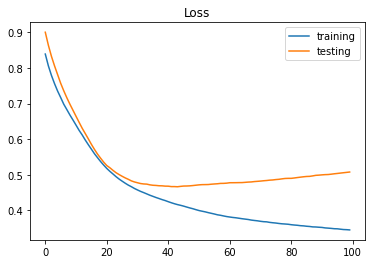

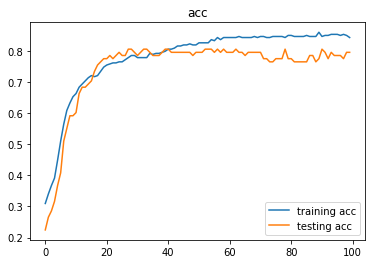

In [14]:
# See how your model is doing
plot_history(history, metrics = ['acc'])

## Evaluation



4/4 [==============================] - 1s 197ms/step
Training Evaluation:

              precision    recall  f1-score   support

 No Diabetes       0.86      0.90      0.88       196
    Diabetes       0.79      0.71      0.75        98

    accuracy                           0.84       294
   macro avg       0.82      0.81      0.82       294
weighted avg       0.84      0.84      0.84       294



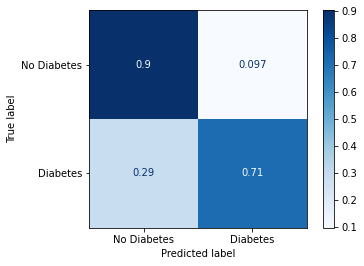

Testing Evaluation:

              precision    recall  f1-score   support

 No Diabetes       0.84      0.86      0.85        66
    Diabetes       0.70      0.66      0.68        32

    accuracy                           0.80        98
   macro avg       0.77      0.76      0.76        98
weighted avg       0.79      0.80      0.79        98



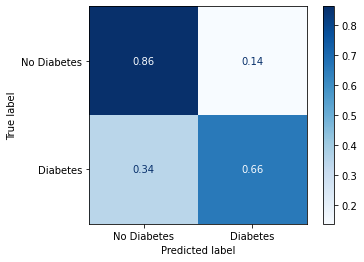

In [15]:
# Make predicitons and evaluate your model
# Define labels for the confusion matrix
labels = ['No Diabetes', 'Diabetes']

# Get predictions and round them to integers instead of floats
train_preds = np.rint(class_model.predict(X_train))
test_preds = np.rint(class_model.predict(X_test))

# Evaluate training set
print('Training Evaluation:\n')
evaluate_classification(y_train, train_preds, labels=labels,
                        normalize='true')
print('Testing Evaluation:\n')
# Confusion Matrix
evaluate_classification(y_test, test_preds, labels=labels,
                        normalize='true')

# 👉 Tuning an underfit model:
##Increase model complexity:
1. add layers  
2. add nodes 
3. reduce other regularization

# 👉 Tuning an overfit model:
## Reduce model complexity:
1. Reduce layers or nodes
2. Add dropout layers
3. Implement early stopping callback
3. Add L1 or L2 regularization


# 🔧 Your Turn: Tune This Model!

* Choose one or more regularization techniques to improve this model.

* Make one change at a time.  Make a new cell for each change to keep a record of what you've tried.

##Ask yourselves:  Should you increase or decrease model complexity?

